# Forecasting with scikit-learn Regressors in sktime




This tutorial demonstrates how to use scikit-learn regression models for time series forecasting in **sktime** through reduction-based strategies.

By the end of this tutorial you will:

- Understand how reduction transforms forecasting into a supervised learning problem  
- Train a scikit-learn regressor for forecasting  
- Build forecasting pipelines  
- Inspect model parameters  

This notebook is intentionally concise and focuses on practical usage.


In [1]:
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_airline
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series


## Reduction-based Forecasting

Reduction converts a time series forecasting problem into a supervised regression task.

Instead of predicting future values directly, we create lagged observations from the past and train a regression model to learn the relationship between them.

This allows us to use the rich ecosystem of scikit-learn models for forecasting.


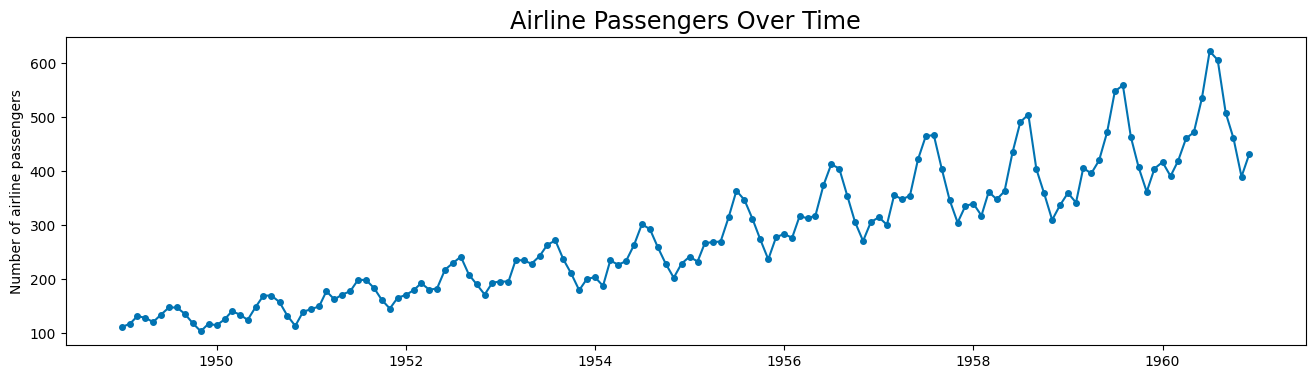

In [2]:
y = load_airline()

plot_series(y, title="Airline Passengers Over Time")
plt.show()


## Creating a Reduction Forecaster

We wrap a scikit-learn regressor using `make_reduction`, which automatically generates lag features.


In [3]:
regressor = RandomForestRegressor(random_state=42)

forecaster = make_reduction(
    regressor,
    window_length=12,
    strategy="recursive"
)


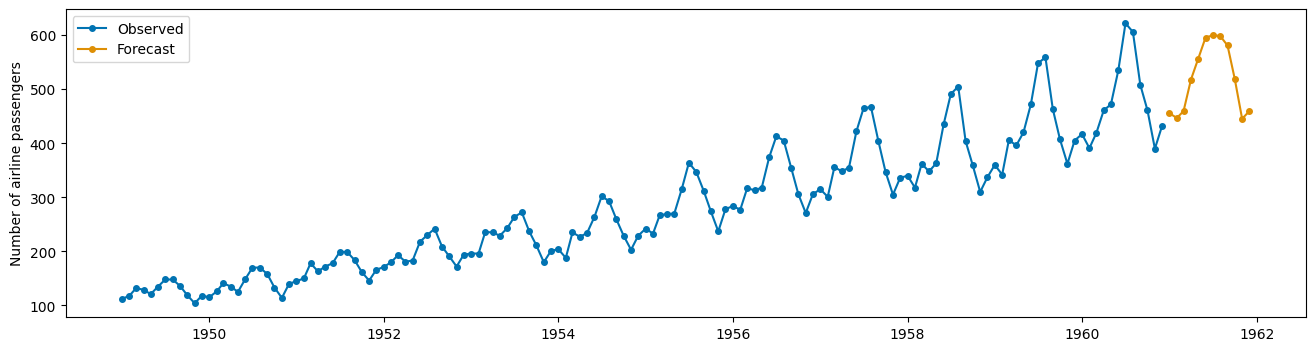

In [4]:
fh = ForecastingHorizon([1,2,3,4,5,6,7,8,9,10,11,12], is_relative=True)

forecaster.fit(y)
y_pred = forecaster.predict(fh)

plot_series(y, y_pred, labels=["Observed", "Forecast"])
plt.show()


## Using Pipelines

Because reduction relies on scikit-learn, we can easily integrate preprocessing steps such as scaling into a pipeline.


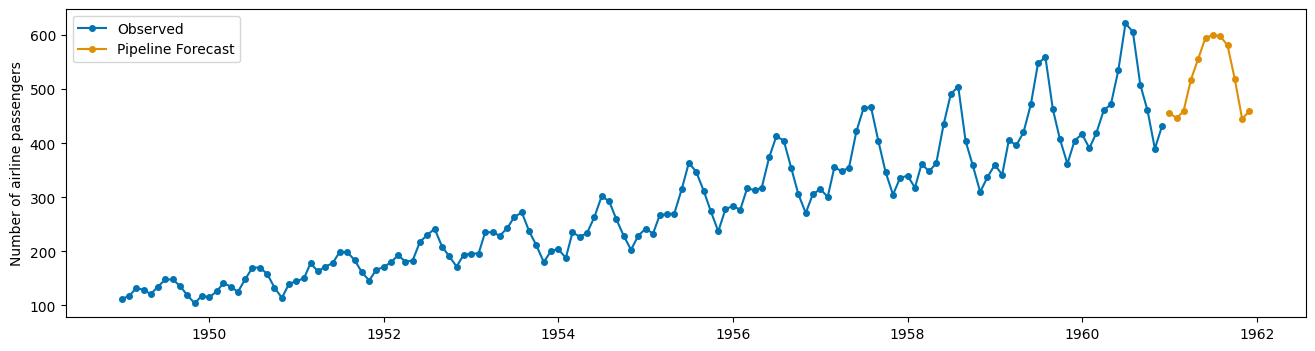

In [5]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42))
])

forecaster_pipeline = make_reduction(
    pipeline,
    window_length=12,
    strategy="recursive"
)

forecaster_pipeline.fit(y)
y_pred_pipe = forecaster_pipeline.predict(fh)

plot_series(y, y_pred_pipe, labels=["Observed", "Pipeline Forecast"])
plt.show()


## Local vs Global Models

Reduction strategies are typically **local**, meaning a separate model is trained for each time series.

Global models, in contrast, learn from multiple series simultaneously and can capture shared patterns. Choosing between them depends on data availability and forecasting goals.


In [6]:
forecaster_pipeline.get_params()

{'estimator': Pipeline(steps=[('scaler', StandardScaler()),
                 ('rf', RandomForestRegressor(random_state=42))]),
 'pooling': 'local',
 'transformers': None,
 'window_length': 12,
 'estimator__memory': None,
 'estimator__steps': [('scaler', StandardScaler()),
  ('rf', RandomForestRegressor(random_state=42))],
 'estimator__transform_input': None,
 'estimator__verbose': False,
 'estimator__scaler': StandardScaler(),
 'estimator__rf': RandomForestRegressor(random_state=42),
 'estimator__scaler__copy': True,
 'estimator__scaler__with_mean': True,
 'estimator__scaler__with_std': True,
 'estimator__rf__bootstrap': True,
 'estimator__rf__ccp_alpha': 0.0,
 'estimator__rf__criterion': 'squared_error',
 'estimator__rf__max_depth': None,
 'estimator__rf__max_features': 1.0,
 'estimator__rf__max_leaf_nodes': None,
 'estimator__rf__max_samples': None,
 'estimator__rf__min_impurity_decrease': 0.0,
 'estimator__rf__min_samples_leaf': 1,
 'estimator__rf__min_samples_split': 2,
 'estimator

Even though the regressor is wrapped inside the forecasting reduction, its parameters remain fully accessible through `get_params()`. This makes tuning and inspection straightforward.


## Key Takeaways

- Reduction enables scikit-learn regressors to solve forecasting tasks  
- Pipelines integrate seamlessly with sktime  
- Model parameters remain accessible for tuning  
- Switching regressors requires minimal code changes  

Reduction offers a flexible and powerful approach for machine learning-based forecasting.
